# Instruction Tuning with Optimizations

Instruction tuning is form of fine-tuning that enhances a model's ability to generalize across diverse tasks. This concept is particularly useful in making models more adaptable and efficient in understanding and executing new instructions, even those they haven't been explicitly trained on.

## Ok, But What is Instruction Tuning?

Instruction tuning differs from supervised fine-tuning (SFT) approach primarily in the nature of the training data. While both methods involve training on **input-output** pairs, instruction tuning adds a critical layer: **instructions**. This additional context helps the model understand the task it is being asked to perform, leading to improved generalization to unseen tasks. Also, as we will see in this notebook, one of the ways of doing instruction tuning helps us skip the trouble of designing task specific heads or loss functions!

### Key Differences:
- **Supervised Fine-Tuning**: Trains models using input examples and their corresponding outputs.
- **Instruction Tuning**: Augments the input-output pairs with instructions, enhancing the model's ability to generalize to new tasks.

### Example

**Supervised Fine-Tuning**:
- **Input**: "Translate this sentence to French: 'The cat is on the mat.'"
- **Output**: "Le chat est sur le tapis."

**Instruction Tuning**:
- **Instruction**: "Translate the following sentence to French."
- **Input**: "The cat is on the mat."
- **Output**: "Le chat est sur le tapis."

By incorporating instructions, the model gains a better understanding of the task, leading to more robust performance across a wider range of tasks.

In this notebook, we will go deeper into the mechanics of instruction tuning and tune our own model.


We covered a few optimization techniques such as **Quantization** and **LoRA** in the previous notebook, here we will leverage those techniques to perform instruction tuning of the latest Llama 3.1 (or Llama 2 if you do not have access yet) to **convert natual language text** to ``SQL``


> Note: This notebook, even though optimized, does not work on colab for LLaMA 3.1 but LLaMA 2 fits on colab T4

> Built with Llama ❤

## Environment Setup

In [1]:
# !pip install -q accelerate peft bitsandbytes transformers trl tensorboardX

In [2]:
# We need this second time on colab as it doesn't pick the latest version
# !pip install --upgrade transformers

## Import Packages

In [ ]:
import os
import torch
from datasets import load_dataset,Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel,get_peft_model
from trl import SFTTrainer

In [ ]:
!export HF_TOKEN="<ADD YOUR TOKEN>"

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Notebook Configurations

In [ ]:
## LLAMA Versions
LLAMA_2 = "2-7b-chat" # fits t4 on colab
LLAMA_3_1 = "3.1-8b-Instruct" # better performing but needs a bigger GPU. Needs access request approved on HF-Hub

base_model_version =  LLAMA_3_1# set to LLAMA_2 if you want to try this notebook on colab

### Model and Dataset Configs

In [ ]:
# The base model from the Hugging Face hub
if base_model_version == LLAMA_3_1:
    base_model_name =  "meta-llama/Meta-Llama-3.1-8B-Instruct"
elif base_model_version == LLAMA_2:
    base_model_name = "NousResearch/Llama-2-7b-chat-hf"
else:
    print(f"This notebook is not setup for Base Model ={base_model_version}")
    base_model_name = "ERROR"

# Dataset
dataset_name = "wikisql"

# Name of the Instruction Tuned model
output_dir = new_model = f"llama-{base_model_version}-SQL-FT"

## Dataset Preparation

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train",trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### What is LLaMA again?
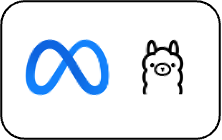

**[LLaMA (Large Language Model Meta AI)](https://ai.meta.com/blog/large-language-model-llama-meta-ai/)**, is a state-of-the-art foundational large language model designed to help researchers advance their work in this subfield of AI. Smaller, more performant models such as LLaMA enable others in the research community who don’t have access to large amounts of infrastructure to study these models, further democratizing access in this important, fast-changing field.
Within this series, Meta has released several versions of different sizes. They have progressively improved in their performance while adjusting how the inputs and prompt formats work.

This notebook works for two smaller sized LLaMAs, version 2-7B and 3.1-8B. 

### General Format for Instructions for LLaMA Models
**LLaMA 2** :
```
[INST]<<SYS>>{system text}<</SYS>>
{user text}[/INST]
{assistant response}
```

**LLaMA 3.1**:
```
<|start_header_id|>system<|end_header_id|>
{system text}
<|eot_id|>\n<|start_header_id|>user<|end_header_id|>
{user text}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
{assistant response}
...
```

We will leverage these formats to prepare our **Instruction Dataset**.

In [ ]:
# [T2SQL]
def fstr_llama_template(model_version,question,output=''):
    template_3_1 = "<|start_header_id|>system<|end_header_id|>\nConvert the following textual question into SQL.<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\nquestion:{question}\noutput:<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>"
    template_3_1_output = "{output}<|end_of_text|>"
    template_2_0 = "[INST]<<SYS>>Convert the following textual question into SQL.<</SYS>>\nquestion:{question}\noutput:[/INST]"
    template_2_0_output = "{output}</s>"
    if model_version == LLAMA_3_1:
        if output !='':
            return eval(f'f"""{template_3_1+template_3_1_output}"""')
        else:
            return eval(f'f"""{template_3_1}"""')
    elif model_version == LLAMA_2:
        if output !='':
            return eval(f'f"""{template_2_0+template_2_0_output}"""')
        else:
            return eval(f'f"""{template_2_0}"""')
    else:
        print(f"This notebook is not setup for Base Model ={template}")
        return "ERROR"

In [ ]:
instruction_formatted_dataset = []
for row in dataset.select(range(25000)):
    instruction_formatted_dataset.append(
        {'text':fstr_llama_template(base_model_version,row['question'],row['sql']['human_readable'])}
    )

In [ ]:
# Transform List to Dataset Object
instruct_datset = Dataset.from_list(instruction_formatted_dataset)

In [ ]:
# Get one sample data point
print(instruct_datset[0]['text'])

<|start_header_id|>system<|end_header_id|>
Convert the following textual question into SQL.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
question:Tell me what the notes are for South Australia 
output:<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>SELECT Notes FROM table WHERE Current slogan = SOUTH AUSTRALIA<|end_of_text|>


## Configurations

### Quantization

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 4-bit precision base model loading
    bnb_4bit_quant_type="nf4", #quantization type
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_storage=torch.bfloat16
)

### QLoRA

In [ ]:
# LoRA rank dimension
lora_r = 64

# Alpha-LoRA for scaling
lora_alpha = 16

# Dropout for LoRA
lora_dropout = 0.1

In [ ]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

### Fine-Tuning Configs

In [ ]:
# Maximum sequence length to use
max_seq_length = 1028

# pack multiple examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

### Training Setup Configs

In [ ]:
# Number of training epochs
num_train_epochs = 1

fp16 = False
bf16 = False # True for A100

# Batch size per GPU for training
per_device_train_batch_size = 4 # increase to 8 for A100

# batch size per GPU for eval
per_device_eval_batch_size = 4

# update steps to accumulate the gradients
gradient_accumulation_steps = 1

gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001

# optimizer
optim = "paged_adamw_32bit"

# learning rate schedule
lr_scheduler_type = "cosine"
max_steps = -1 # setting this will override num_train_epochs, do not change
warmup_ratio = 0.03

# speeds up training considerably by grouping samples by length
group_by_length = True
save_steps = 0
logging_steps = 25

## Load base model

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map=device_map,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

## Load LLaMA tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Set training parameters

In [ ]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

## Set Supervised Fine-Tuning Parameters

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=instruct_datset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

## Time to Fine Tune our T2SQL LLaMA

In [ ]:
#25k samples take 1hr 10mins on avg on A100PCIe
trainer.train()

Step,Training Loss
25,5.882800
50,4.674900
75,2.112600
100,1.252100
125,1.408200
150,1.072900
175,1.214300
200,0.873300
225,1.166800
250,0.847000


TrainOutput(global_step=6250, training_loss=0.8897534890747071, metrics={'train_runtime': 4493.7158, 'train_samples_per_second': 5.563, 'train_steps_per_second': 1.391, 'total_flos': 6.864998517640397e+16, 'train_loss': 0.8897534890747071, 'epoch': 1.0})

## Save T2SQL Model

In [ ]:
trainer.model.save_pretrained(new_model)

In [ ]:
# uncomment if you want to push to hub for using this later
# model.push_to_hub(new_model,commit_message="training_complete")
# tokenizer.push_to_hub(new_model,commit_message="uploading tokenizer")

## Let Us Convert Some Text to SQL

In [ ]:
questions = [
    "What is the description of a ch-47d chinook?",
    "What is the current series where the new series began in June 2011",
    "How many students are between the ages of 10 and 30"
]

In [ ]:
lora_config = LoraConfig.from_pretrained(f"raghavbali/{new_model}")
# hf_tokenizer = AutoTokenizer.from_pretrained(f"raghavbali/{new_model}")

hf_ft_model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    use_auth_token=True,
    device_map=device_map)

In [ ]:
# # uncomment only if you have bigger than T4 GPU
# base_model = AutoModelForCausalLM.from_pretrained(
#     base_model_name,
#     quantization_config=bnb_config,
#     device_map=device_map,
#     use_auth_token=True,
# )

### Apply LoRA Adaptors

In [ ]:
hf_ft_peft_model = get_peft_model(hf_ft_model, lora_config)
print(hf_ft_peft_model.dtype)
print(hf_ft_model.num_parameters())

torch.float16
8057524224


In [ ]:
from IPython.display import display, Markdown

In [ ]:
for question in questions:
    prompt = fstr_llama_template(base_model_version,question)
    inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
    print("----INSTRUCT-TUNED-MODEL ----")
    outputs = hf_ft_peft_model.generate(**inputs,max_new_tokens=50, temperature=0.2)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    print("---- NON-INSTRUCT-TUNED-MODEL ----")
    outputs = base_model.generate(**inputs, max_new_tokens=50)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    print("---- END ----")

----INSTRUCT-TUNED-MODEL ----


system
Convert the following textual question into SQL.
user
question:What is the description of a ch-47d chinook?
output:
assistant

Here is the SQL query that corresponds to the question:

```sql
SELECT description
FROM aircraft
WHERE model = 'CH-47D Chinook';
```

Assuming we have a table named `aircraft` with columns `model`

----INSTRUCT-TUNED-MODEL ----


system
Convert the following textual question into SQL.
user
question:What is the current series where the new series began in June 2011
output:
assistant

SQL query:
```sql
SELECT series_name
FROM series
WHERE start_date = '2011-06-01';
```
Assuming the table structure is:
```sql
CREATE TABLE series (
  series_id INT PRIMARY KEY,
 

----INSTRUCT-TUNED-MODEL ----


system
Convert the following textual question into SQL.
user
question:How many students are between the ages of 10 and 30
output:
assistant

Here is the SQL query that corresponds to the question:

```sql
SELECT COUNT(*)
FROM students
WHERE age BETWEEN 10 AND 30;
```

Assuming that the table name is `students` and the column name is `age